# Data exploration

date: 2022-09-04

## Introduction

Basic, initial data exploration.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import janitor  # noqa: F401
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from breezy import data as bd
from breezy import plotting as bp

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
bp.set_breezy_theme()

### Data

In [5]:
kras_mut_freq = bd.cbioportal_kras_freq(cancer_type_inorder=True)
kras_mut_freq.head(3)

,cancer_type,alteration_frequency,alteration_type,alteration_count
0,Pancreatic Cancer,4.347826,multiple,8
1,Pancreatic Cancer,59.239130,mutated,109
2,Colorectal Cancer,0.505051,multiple,3


In [6]:
alterations = kras_mut_freq["alteration_type"].cat.categories
alteration_pal = {k: sns.color_palette("tab10")[i] for i, k in enumerate(alterations)}

In [7]:
gtex_expr = bd.gtex_expression_data()
gtex_expr.head(3)

,expr,dataset_id,gencode_id,gene_symbol,source,unit
0,17.12,gtex_v8,ENSG00000133703.11,KRAS,thyroid,TPM
1,13.74,gtex_v8,ENSG00000133703.11,KRAS,thyroid,TPM
2,11.52,gtex_v8,ENSG00000133703.11,KRAS,thyroid,TPM


In [8]:
hpa_expr = bd.hpa_expression_data()
hpa_expr.head(3)

,gene,data_type,source,unit,expr
0,KRAS,Tissue RNA,adipose tissue,nTPM,11.8
1,KRAS,Tissue RNA,adrenal gland,nTPM,9.1
2,KRAS,Tissue RNA,amygdala,nTPM,11.0


In [9]:
hpa_expr["data_type"].unique()

array(['Tissue RNA', 'Cell RNA', 'Blood RNA', 'Brain RNA',
       'Single Cell Type RNA'], dtype=object)

In [10]:
tm_expr = bd.tabula_muris_data()
tm_expr.head(3)

,cell_id,tissue,cell_type,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,tissue_tsne_1,tissue_tsne_2,n_genes_by_counts,total_counts,kras_expr,kras_log_expr
0,A21.MAA000594.3_8_M.1.1,Aorta,fibroblast,fibroblast,CL:0000057,3,NaN,3_8_M,M,MAA000594,-15.322284,-5.440012,3861,1876233.0,0.0,0.0
1,F8.MAA000594.3_8_M.1.1,Aorta,erythrocyte,erythrocyte,CL:0000232,0,NaN,3_8_M,M,MAA000594,7.898756,-6.459818,807,122044.0,0.0,0.0
2,H11.MAA000594.3_8_M.1.1,Aorta,erythrocyte,erythrocyte,CL:0000232,0,NaN,3_8_M,M,MAA000594,14.039970,-3.910648,573,369006.0,0.0,0.0


## Analysis

### Mutation frequency from cBioPortal

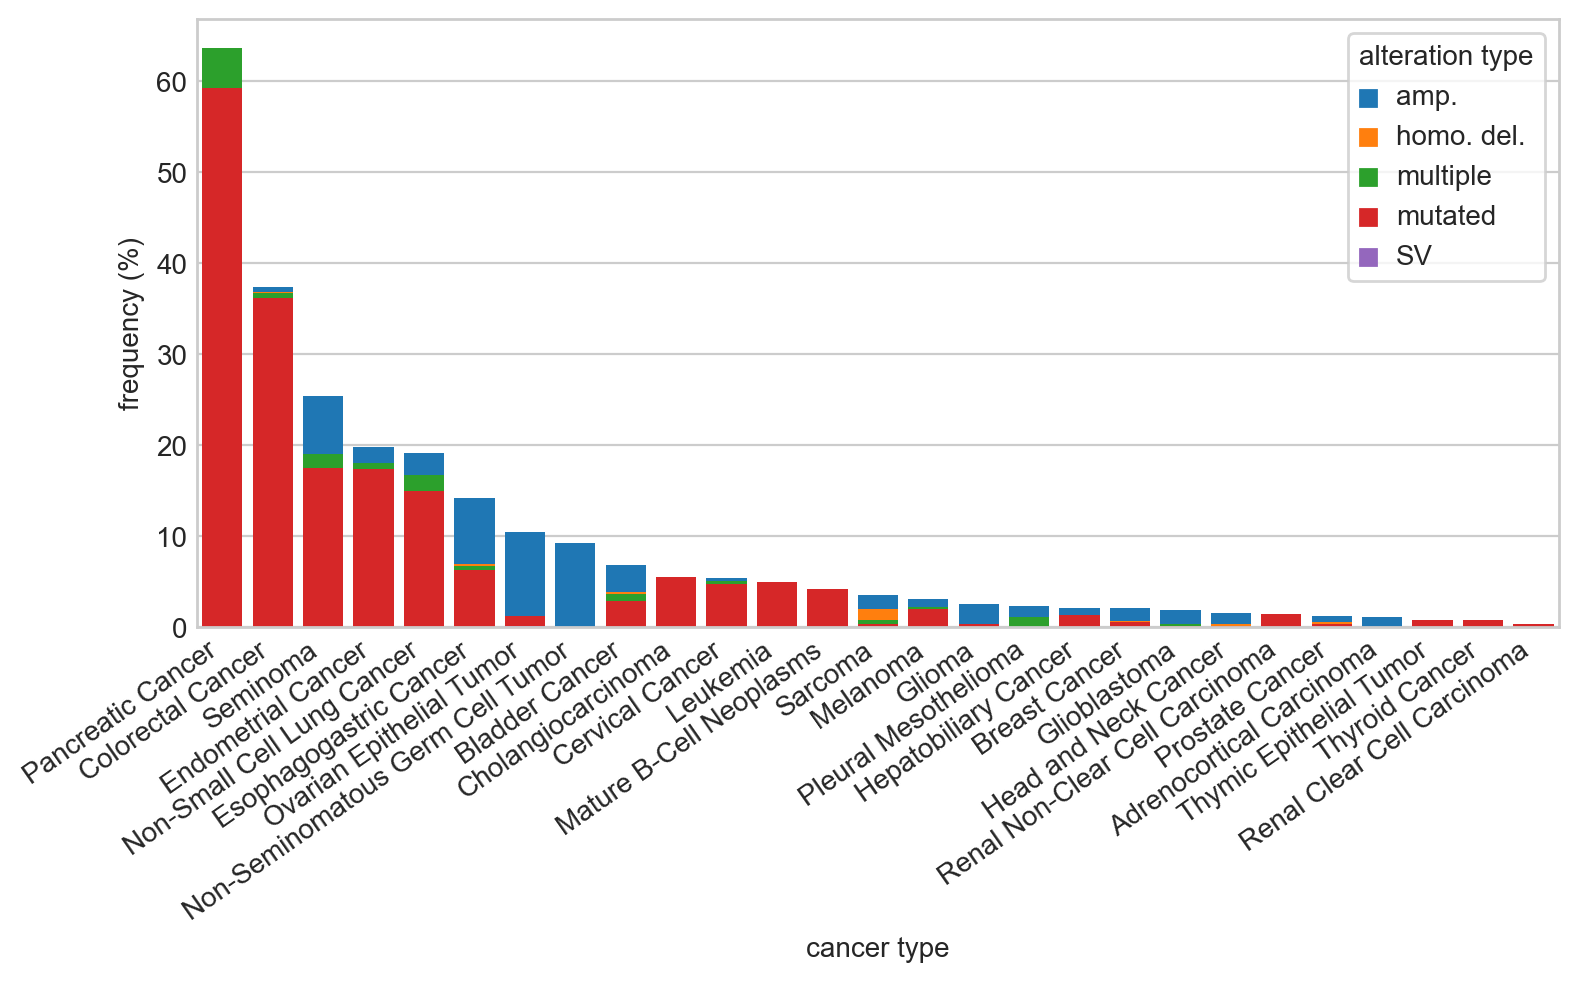

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.histplot(
    kras_mut_freq,
    x="cancer_type",
    hue="alteration_type",
    weights="alteration_frequency",
    multiple="stack",
    shrink=0.8,
    palette=alteration_pal,
    alpha=1,
    lw=0,
)
ax.grid(visible=False, axis="x")

xlabels = kras_mut_freq["cancer_type"].cat.categories
ax.set_xlim(-0.5, len(xlabels) - 0.5)
ax.set_xticks(ticks=np.arange(len(xlabels)), labels=xlabels, rotation=35, ha="right")


ax.legend(
    handles=bp.pal_to_legend_handles(alteration_pal, marker="s", lw=0),
    title="alteration type",
    loc="upper right",
    handletextpad=1,
    handlelength=0,
    handleheight=0,
    frameon=True,
)
ax.set_ylabel("frequency (%)")
ax.set_xlabel("cancer type")
fig.tight_layout()
plt.show()

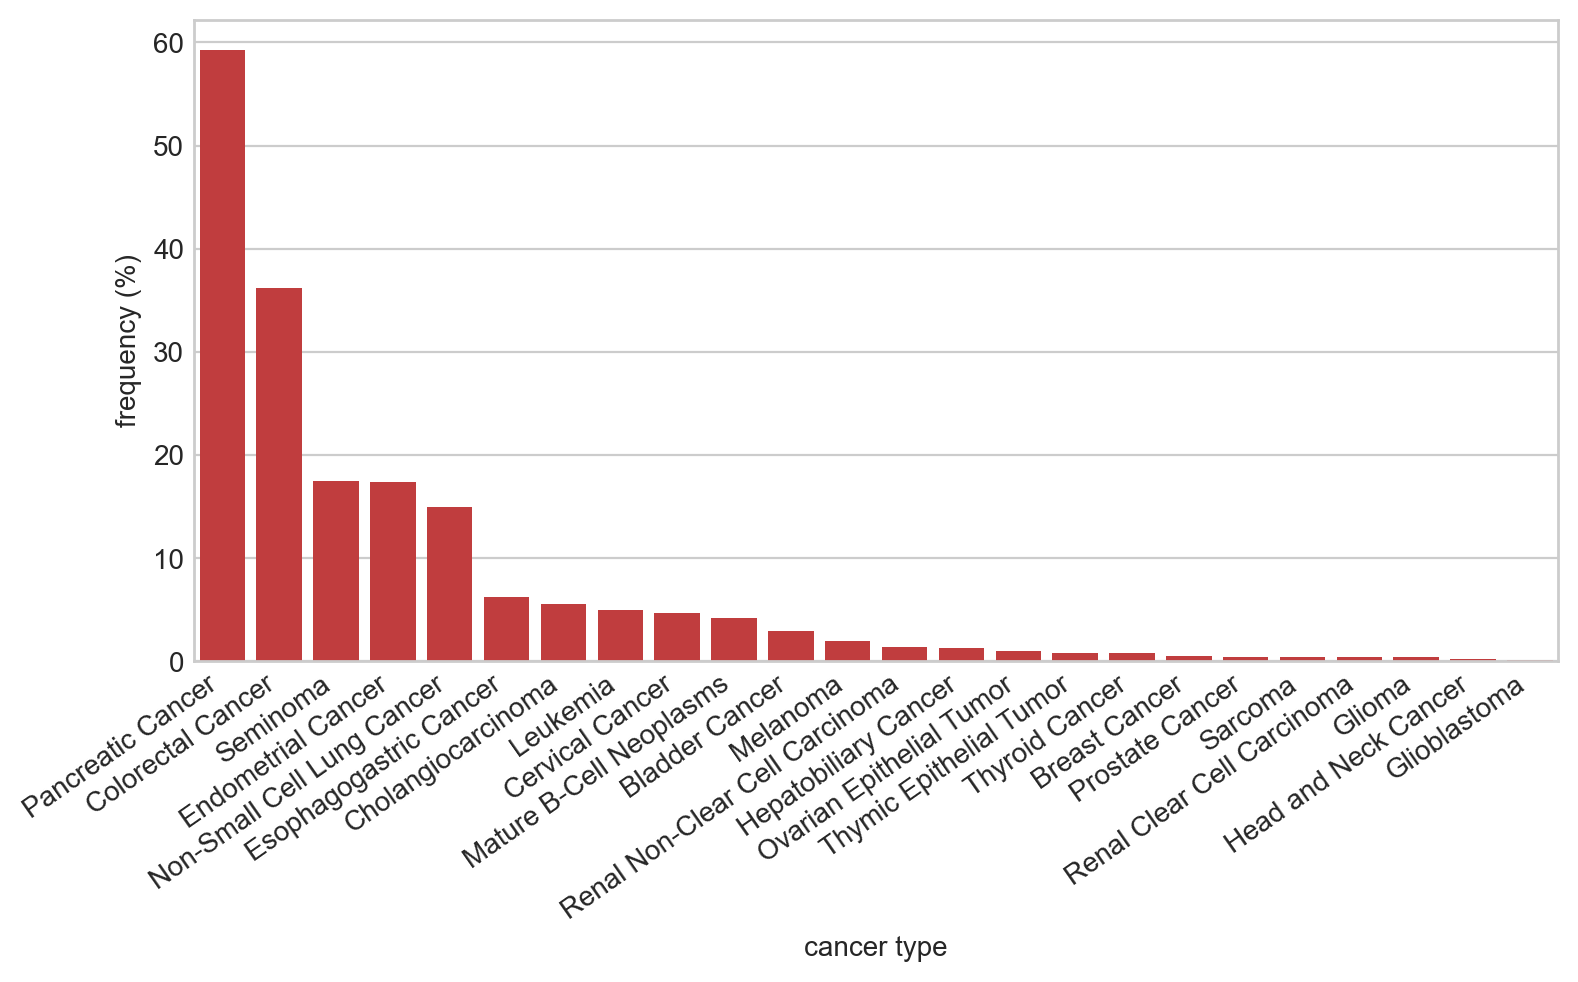

In [12]:
mutation_freqs = (
    kras_mut_freq.query("alteration_type == 'mutated'")
    .sort_values("alteration_frequency", ascending=False)
    .reset_index(drop=True)
)
new_cancer_order = mutation_freqs["cancer_type"].astype("str").unique()
mutation_freqs["cancer_type"] = pd.Categorical(
    new_cancer_order, categories=new_cancer_order
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=mutation_freqs,
    x="cancer_type",
    y="alteration_frequency",
    color=alteration_pal["mutated"],
)


xlabels = mutation_freqs["cancer_type"].cat.categories
ax.set_xlim(-0.5, len(xlabels) - 0.5)
ax.set_xticks(ticks=np.arange(len(xlabels)), labels=xlabels, rotation=35, ha="right")

ax.set_ylabel("frequency (%)")
ax.set_xlabel("cancer type")
fig.tight_layout()
plt.show()

### GTEx expression data

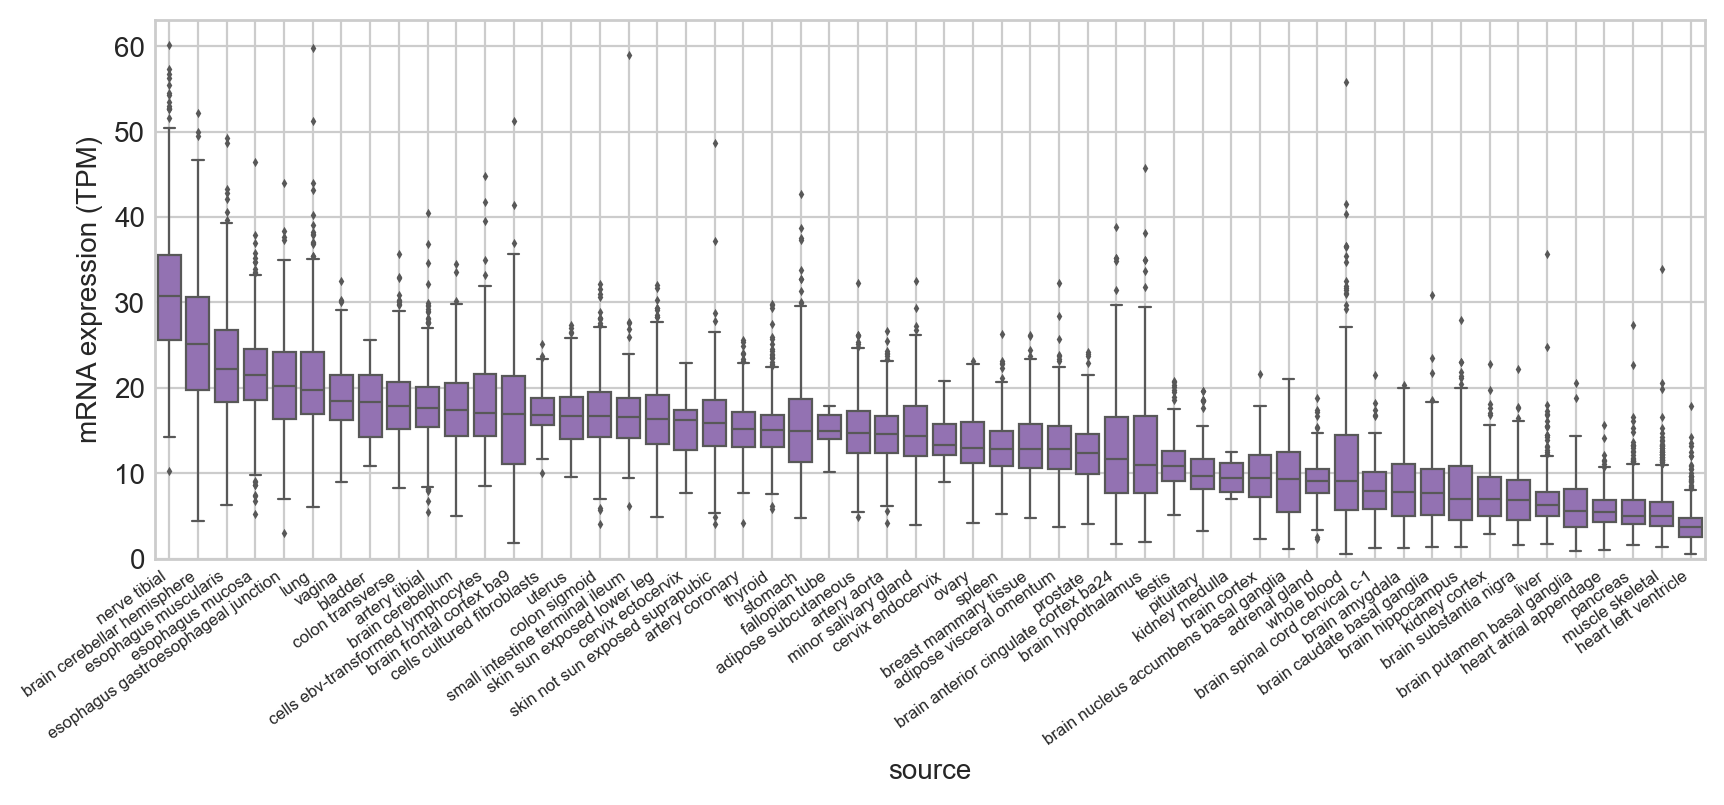

In [13]:
median_order = (
    gtex_expr.groupby("source")["expr"]
    .median()
    .reset_index()
    .sort_values("expr", ascending=False)["source"]
    .values
)
plot_df = gtex_expr.copy()
plot_df["source"] = pd.Categorical(plot_df["source"], categories=median_order)

fig, ax = plt.subplots(figsize=(10, 3.5))
sns.boxplot(
    data=plot_df,
    x="source",
    y="expr",
    fliersize=1,
    ax=ax,
    linewidth=0.8,
    color="tab:purple",
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=35,
    ha="right",
    size=6,
)
ax.grid(visible=True, axis="x")
ax.set_xlabel("source")
ax.set_ylabel("mRNA expression (TPM)")
ax.set_ylim(0, None)
plt.show()

### Human Protein Atlas cell-type expression

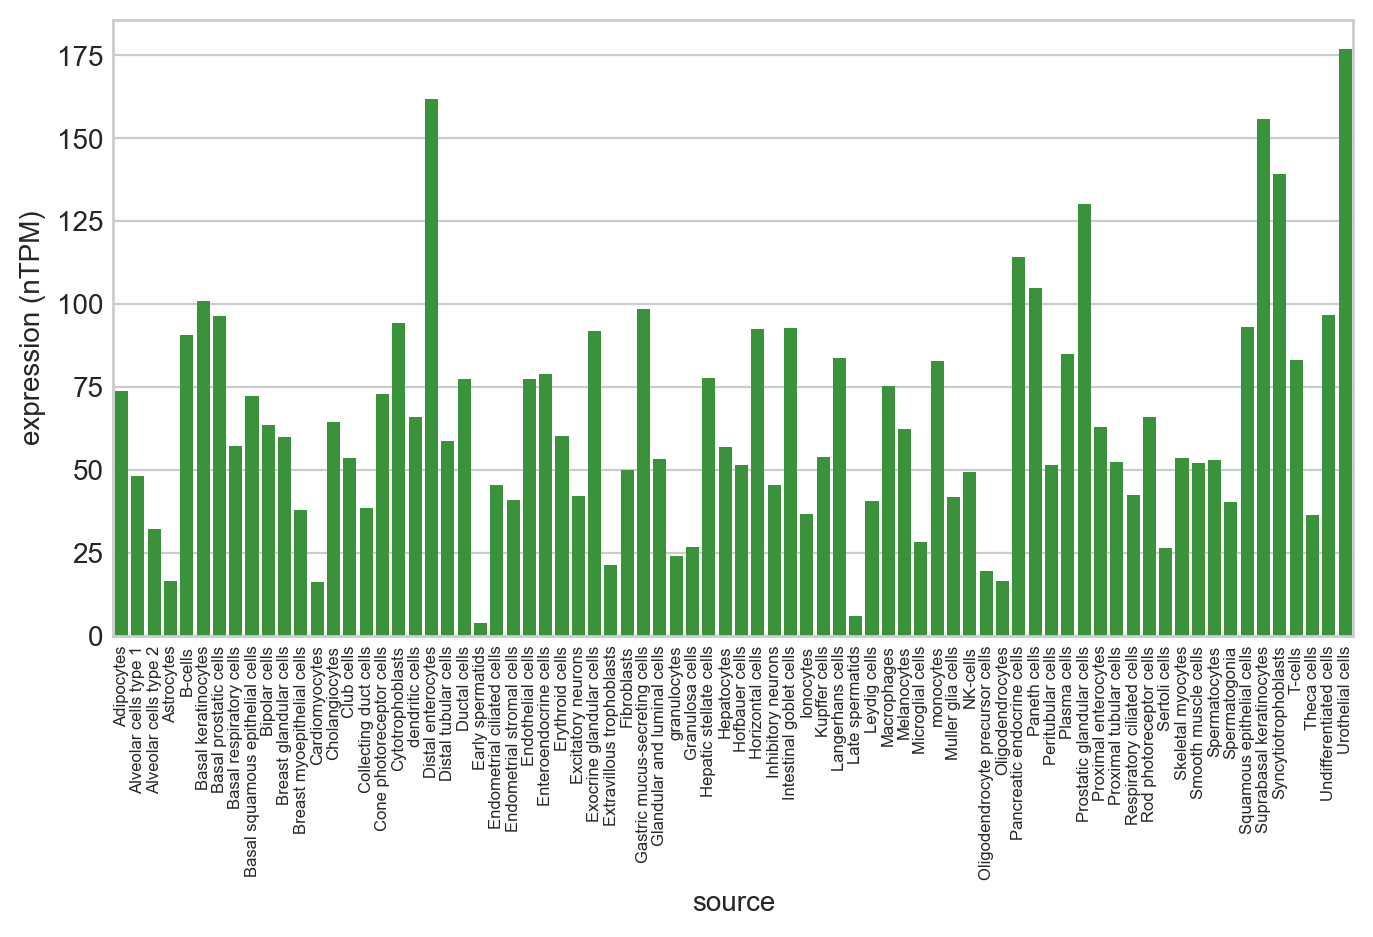

In [14]:
hpa_single_cell = (
    hpa_expr.copy()
    .filter_column_isin("data_type", ["Single Cell Type RNA"])
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(data=hpa_single_cell, x="source", y="expr", ax=ax, color="tab:green")
ax.tick_params("x", rotation=90, labelsize=6)
ax.set_xlabel("source")
ax.set_ylabel("expression (nTPM)")
plt.show()

### Tabula Muris

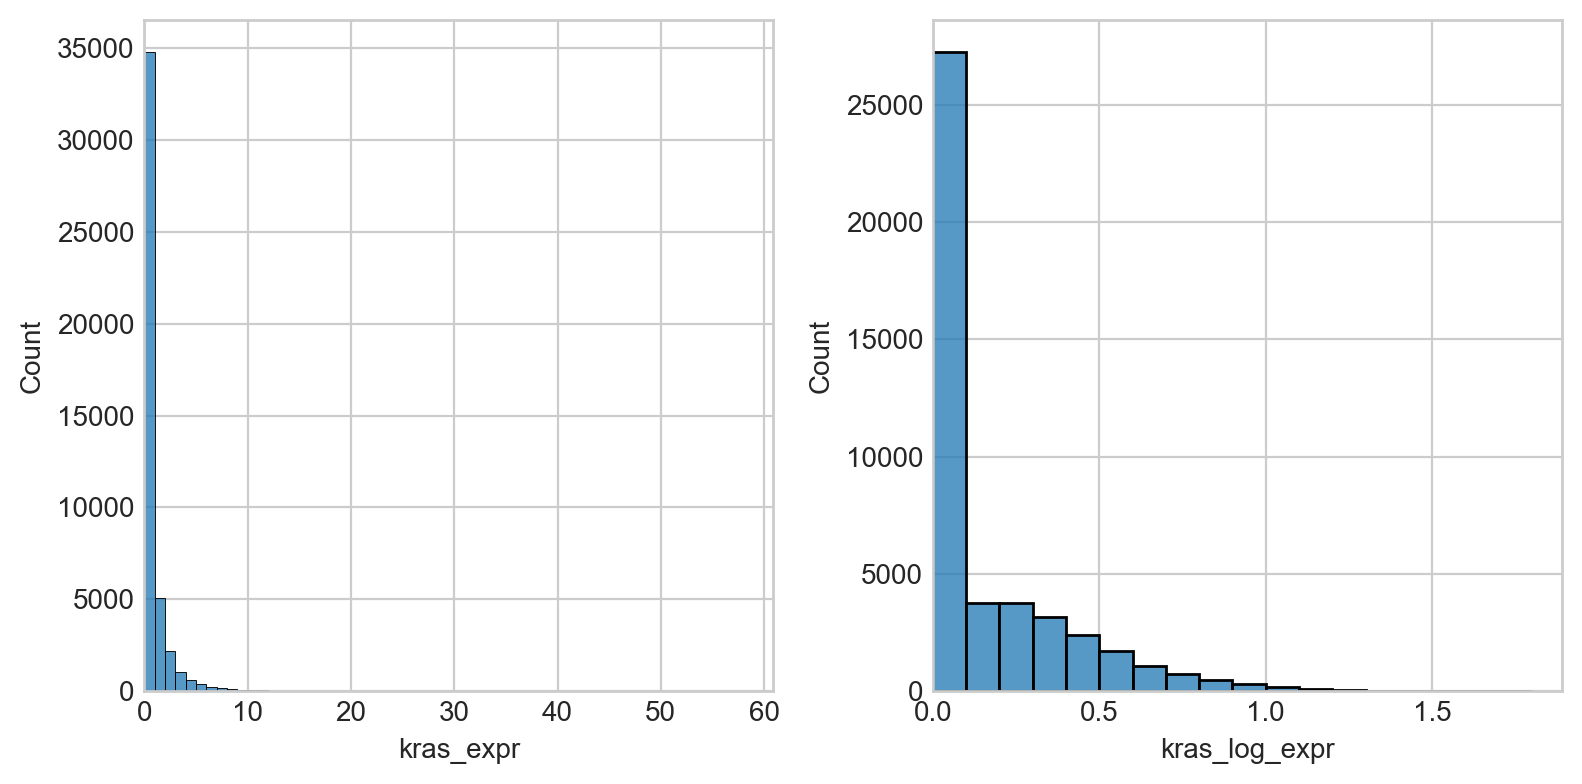

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
sns.histplot(data=tm_expr, x="kras_expr", binwidth=1, ax=axes[0])
sns.histplot(data=tm_expr, x="kras_log_expr", binwidth=0.1, ax=axes[1])
for ax in axes:
    ax.set_xlim(0, None)

fig.tight_layout()
plt.show()

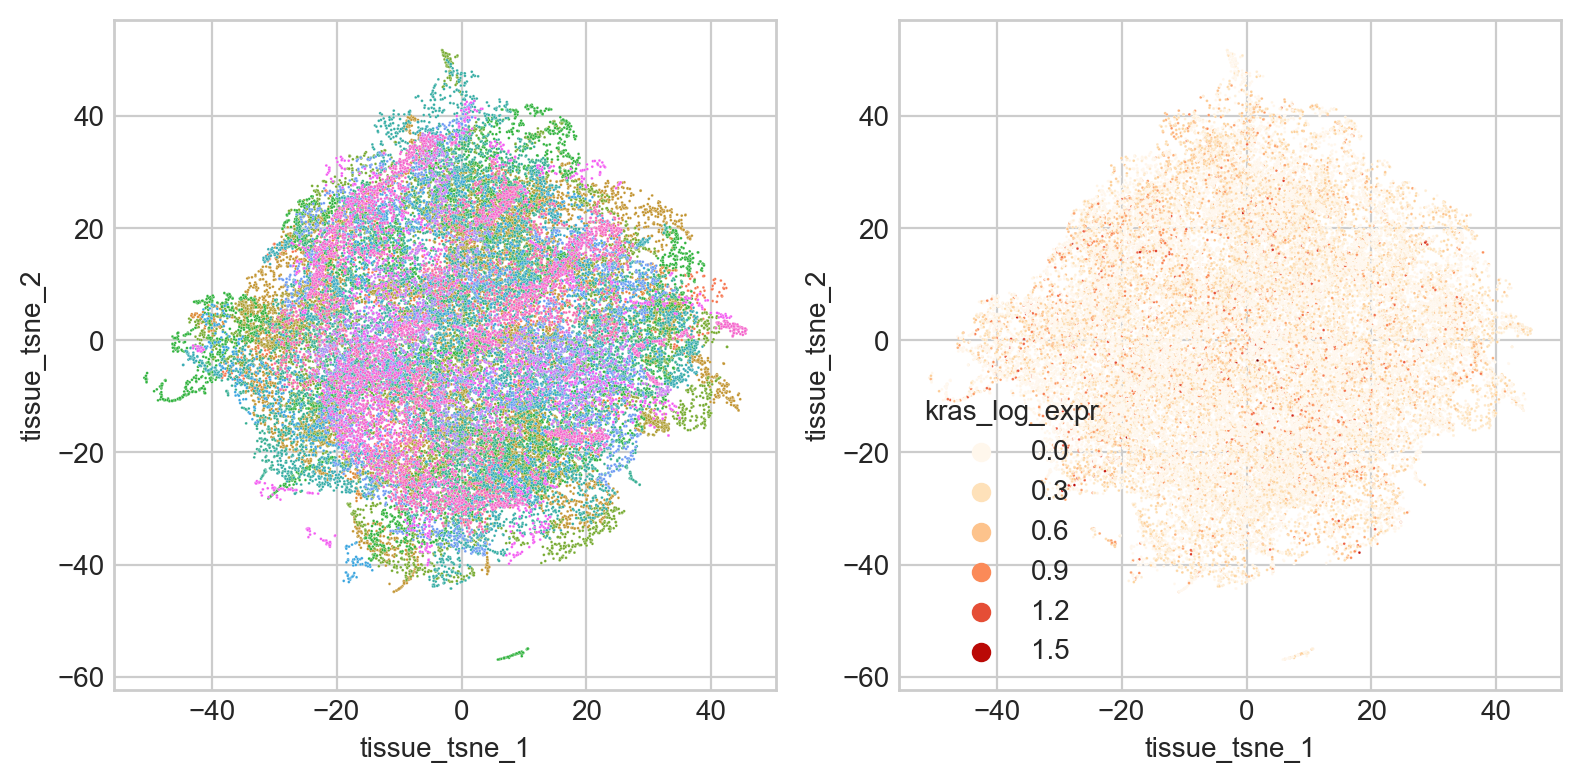

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sns.scatterplot(
    data=tm_expr,
    x="tissue_tsne_1",
    y="tissue_tsne_2",
    hue="tissue",
    s=1,
    edgecolors=None,
    ax=axes[0],
    legend=False,
)

sns.scatterplot(
    data=tm_expr,
    x="tissue_tsne_1",
    y="tissue_tsne_2",
    hue="kras_log_expr",
    palette="OrRd",
    s=1,
    edgecolors=None,
    ax=axes[1],
    # legend=False
)

fig.tight_layout()
plt.show()

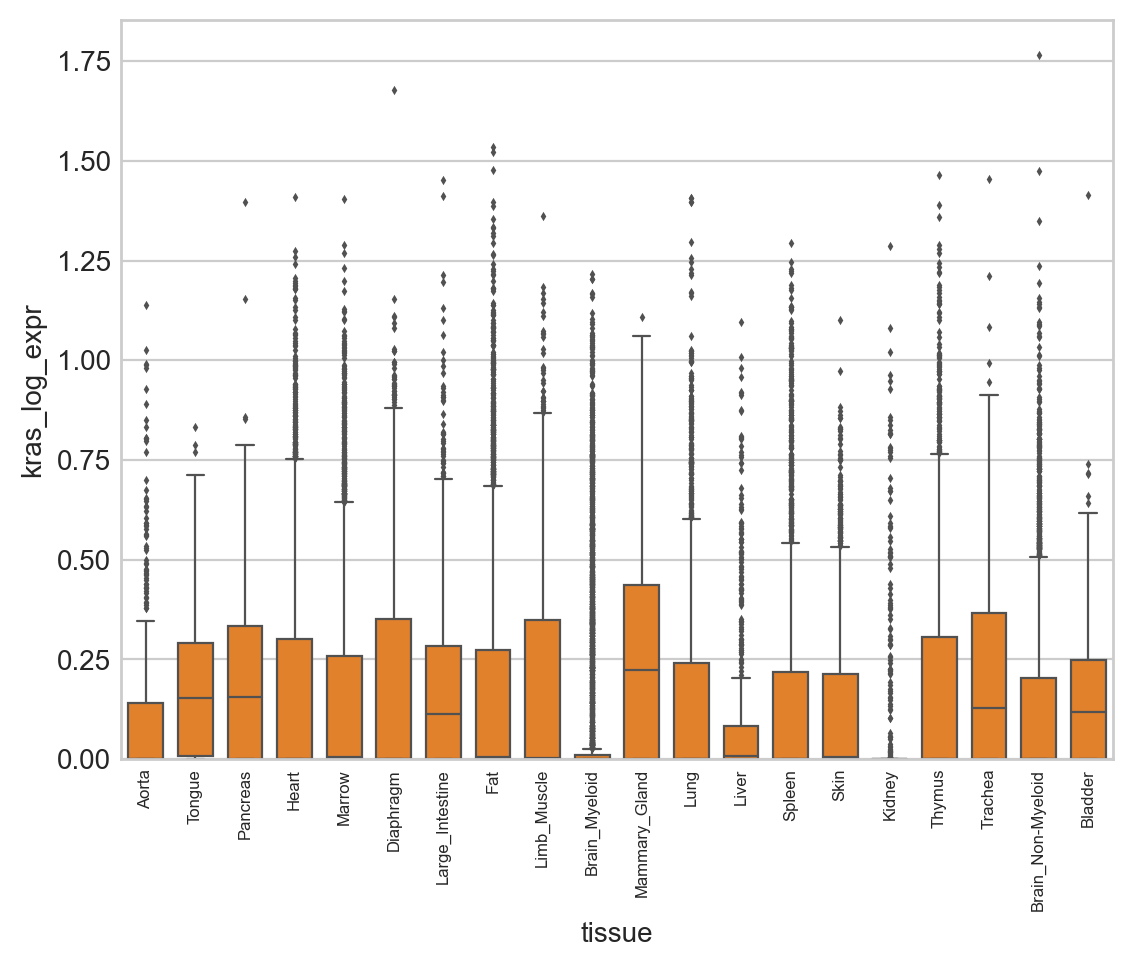

In [17]:
ax = sns.boxplot(
    data=tm_expr,
    x="tissue",
    y="kras_log_expr",
    fliersize=1,
    linewidth=0.8,
    color="tab:orange",
    width=0.7,
)
ax.set_ylim(0, None)
ax.tick_params("x", rotation=90, labelsize=6)
plt.show()

---

## Session Info

In [18]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-09-15

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: eda

seaborn   : 0.11.2
breezy    : 0.0.1
janitor   : 0.22.0
numpy     : 1.23.2
pandas    : 1.4.4
matplotlib: 3.5.3

